In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader
#from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import statistics
import matplotlib.pyplot as plt
import csv


seed = 42
torch.manual_seed(seed)

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:5" # change the available gpu number
else:
    device = "cpu"

## Load Dataset

In [3]:
# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Parameters

In [15]:
num_classes = 10
subset_fraction = 0.1
num_runs = 1
split_ratio = 0.9
epochs = 100
model_name = "LeNet"
submod_func = "facility-location"
optimizer_name = "adam"

## Load Model

In [7]:
from models.LeNet_model import LeNet
from models.resent_models import get_resent101_model, get_resent18_model

model = LeNet(out_classes=num_classes)

In [8]:
from utils.milo.subset_sampler import RandomSubsetSampler
from utils.milo.subset_dataset import SubDataset

## Experiment 

#### Optimizer

In [16]:
if optimizer_name=="SGD_ann":
    optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
elif optimizer_name=="adam":
    optimizer = torch.optim.Adam(model.parameters())

#### Train Loop

In [10]:
import os
print(os.getcwd())

/raid/ganesh/namitha/yash/BTP/neural-submod


In [18]:
with open("./data/seq_submod_subset/permutation_subsets/facility-location_disparity-sum_disparity-min_graph-cut.pkl", "rb") as f:
    data = pickle.load(f)

In [1]:
import os 
path = "./data/seq_submod_subset/permutation_subsets/"
dir_list = os.listdir(path) 

disparity-min_graph-cut_facility-location_disparity-sum.pkl


100%|██████████| 100/100 [12:55<00:00,  7.76s/it]


--- 775.9244446754456 seconds ---


100%|██████████| 157/157 [00:01<00:00, 110.13it/s]


accuracy: 0.6608


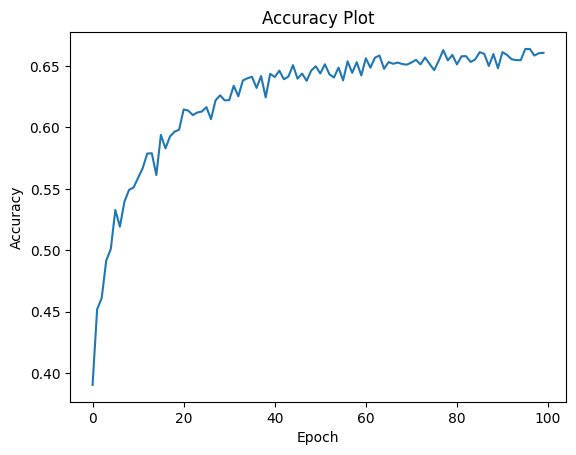

TypeError: write() argument must be str, not float

In [22]:
for exp_data_file in dir_list:
    if exp_data_file.endswith(".pkl"):
        try:
            with open(f"./data/seq_submod_subset/permutation_subsets/{exp_data_file}") as f:
                data = pickle.load(f)
        except:
            print(f"Error while loading {exp_data_file}")

    if model_name=="LeNet":
        model = LeNet()
    elif model_name=="resnet18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()

    model = model.to(device=device)
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name=="SGD_ann":
        optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    elif optimizer_name=="adam":
        optimizer = torch.optim.Adam(model.parameters())

    # Train the model
    model.train()
    start_time = time.time()

    accuracy_list = []

    for epoch in tqdm(range(epochs)):
        # Train loop
        if epoch==0:
            sub_dataset = SubDataset(indices=data[0], dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        elif epoch==50:
            sub_dataset = SubDataset(indices=data[1], dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        elif epoch==100:
            sub_dataset = SubDataset(indices=data[2], dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        
            
        for images, labels in subset_train_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and update weights
            if optimizer_name=="SGD_ann":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()  # Update model weights
                lr_scheduler.step()     
            elif optimizer_name=="adam":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate on test set
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        accuracy_list.append(accuracy)

    time_taken = time.time() - start_time    
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"accuracy: {accuracy}")

    x = range(epochs)

    # Plot the accuracies
    plt.plot(x, accuracy_list)

    # Customize the plot (optional)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{exp_data_file.split('.')[0]} Accuracy Plot")

    # Display the plot
    # plt.show()
    plt.savefig(f"./results/plots/{exp_data_file.split('.')[0]}")


    with open(f"./results/accuracies/{exp_data_file.split('.')[0]}", "w") as f:
        f.write(accuracy_list)
    
    with open(f"./results/accuracies.csv", "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(accuracy_list)